## Exploring zero-shot classification using K-NN of DINO class token features

In [1]:
import torch
from torchvision.transforms import Normalize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from model_lora_vit import get_vit, load_lora_vit_from_dino_ckpt
from data_transforms import get_deterministic_transform
from dataloader_tmed import TMED2

torch.hub.set_dir("../pretrained_weights")

In [2]:
# configure the GPU
device = 0 if torch.cuda.is_available() else "cpu"

In [3]:
# load the backbone model, ensure params are consistent with ckpt
experiment = 'imagenet'
if experiment == 'imagenet':
    ckpt_path = None
    lora_rank = 0
elif experiment == 'full':
    ckpt_path = '../logs/training_base/checkpoint.pth'
    lora_rank = 0
elif experiment == 'lora4':
    ckpt_path = '../logs/training_1/checkpoint0009.pth'
    lora_rank = 4
else:
    raise ValueError()

arch = 'vit_small'
patch_size = 8
if ckpt_path == None:
    # load the default DINO model
    model = get_vit(arch, patch_size, lora_rank=0)
else:
    model = get_vit(arch, patch_size, lora_rank)
    load_lora_vit_from_dino_ckpt(model, ckpt_path)
model.to(device).eval()

Using cache found in ../pretrained_weights/facebookresearch_dino_main


Initialized without LoRA


Lora_vit(
  (base): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): LayerNorm((384,

In [4]:
# load the dataset
transform = get_deterministic_transform()
tr_dataset = TMED2(
    split = "train", # train/val/test/all/unlabeled
    transform = transform,
    parasternal_only = True,
    label_scheme_name = 'tufts',
)
tr_dataloader = torch.utils.data.DataLoader(tr_dataset, batch_size=1, shuffle=False)

va_dataset = TMED2(
    split = "val", # train/val/test/all/unlabeled
    transform = transform,
    parasternal_only = True,
    label_scheme_name = 'tufts',
)
va_dataloader = torch.utils.data.DataLoader(va_dataset, batch_size=1, shuffle=False)

### First take a look at the image pipeline 
DINO accepts BxCxHxW dimensionality. 

Images are normalized using ImageNet weights, which were used to train DINO.

When visualizing the batch, we have to un-normalize the image and permute the image dimensions to HxWxC.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054133326..1.0480889].


target_AS: tensor([2])
view: tensor([0])
cine shape: torch.Size([1, 3, 224, 224])


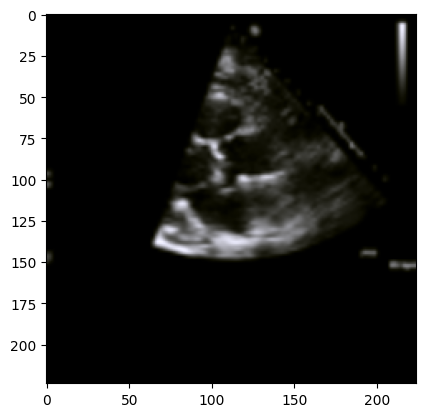

In [5]:
# visualize one batch
data_iter = iter(tr_dataloader)
x, [y, y_view] = next(data_iter)
print(
        f"target_AS: {y}\n"
        f"view: {y_view}\n"
        f"cine shape: {x.shape}"
    )
def unnormalize(im):
    # reverses Imagenet/DINO normalization
    # assumes input size is 3xHxW
    inv_normalize = Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.255], inplace=True)
    return inv_normalize(im)

vis_cine = unnormalize(x[0])
plt.imshow(vis_cine.cpu().numpy().transpose(1,2,0))
plt.show()
plt.close('all')

In [6]:
# in the zero-shot setting, we use exclusively the embedding for K-NN style classification
# to begin, we generate the training set embeddings and labels

def get_embs_and_labels(loader):
    embedding, view, as_label = [], [], []
    for item in tqdm(loader):
        x, [y, y_v] = item
        view.append(y_v)
        as_label.append(y)
        x = x.to(device)
        with torch.no_grad():
            emb = model.forward(x).cpu().numpy()
        embedding.append(emb)
    embedding = np.array(embedding)
    view = torch.cat(view).cpu().numpy()
    as_label = torch.cat(as_label).cpu().numpy()
    return embedding, view, as_label

tr_x, tr_v, tr_y = get_embs_and_labels(tr_dataloader)
va_x, va_v, va_y = get_embs_and_labels(va_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████| 1310/1310 [00:20<00:00, 65.34it/s]


In [7]:
tr_x = tr_x.squeeze()
va_x = va_x.squeeze()

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
# perform knn classification and predict on the validation set
def zero_shot_knn(tr_x, tr_y, va_x, va_y):
    
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(tr_x, tr_y)
    va_pred = neigh.predict_proba(va_x)
    pred_label = np.argmax(va_pred, axis=1)
    pred_confidence = np.max(va_pred, axis=1)
    print(classification_report(va_y, pred_label))
    print(pd.crosstab(va_y, pred_label))
    return pred_label, pred_confidence

as_pred, as_max = zero_shot_knn(tr_x, tr_y, va_x, va_y)
v_pred, v_max = zero_shot_knn(tr_x, tr_v, va_x, va_v)

              precision    recall  f1-score   support

           0       0.44      0.33      0.37       286
           1       0.29      0.24      0.26       187
           2       0.72      0.81      0.76       837

    accuracy                           0.62      1310
   macro avg       0.48      0.46      0.47      1310
weighted avg       0.60      0.62      0.61      1310

col_0   0   1    2
row_0             
0      93  34  159
1      34  44  109
2      84  74  679
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       965
           1       0.85      0.76      0.80       345

    accuracy                           0.90      1310
   macro avg       0.89      0.86      0.87      1310
weighted avg       0.90      0.90      0.90      1310

col_0    0    1
row_0          
0      920   45
1       83  262
